# Tutorial 4

## Mean Squared Displacement (MSD)


Molecules in liquds, gases and solids do not stay in the same place and move constantly. Think about a drop of dye in a glass of water, as time passes the dye distributes throughout the water. This process is called diffusion and is common throughout nature and an incredibly relevant property for materials scientists who work on things like batteries.  

Using the dye as an example, the motion of a dye molecule is not simple. As it moves it is jostled by collisions with other molecules, preventing it from moving in a straight path. If the path is examined in close detail, it will be seen to be a good approximation to a random walk. In mathmatics a random walk is a series of steps, each taken in a random direction. This was analysed by Albert Einstein in a study of Brownian motion and he showed that the mean square of the distance travelled by a particle following a random walk is proportional to the time elapsed. 

\begin{align}
\Big \langle r_{i}^{2} \big \rangle & = 6 D_t + C 
\end{align}


where 

\begin{align}
\Big \langle r_{i}^{2} \big \rangle = \frac{1}{3} \Big< | r_{i}(t) - r_{i}(0) |^2 \Big>.
\end{align}


where $\Big \langle r^2 \big \rangle$ is the mean squared distance, t is time, $D_t$ is the diffusion rate and C is a constant. If $\Big \langle r_{i}^{2} \big \rangle$ is plotted as a function of time, the gradient of the curve obtained is equal to 6 times the self-diffusion coefficient of particle i. 
The state of the matter effects the shape of the MSD plot, solids, where little to no diffusion is occuring, has a flat MSD profile. In a liquid however, the particles diffusion randomly and the gradient of the curve is proportional to the diffusion coefficient. 

## What is the mean squared displacement

Going back to the example of the dye in water, lets assume for the sake of simplicity that we are in one dimension. Each step can either be forwards or backwards and we cannot predict which. From a given starting position, what distance is our dye molecule likely to travel after 1000 steps? This can be determined simply by adding together the steps, taking into account the fact that steps backwards subtract from the total, while steps forward add to the total. Since both forward and backward steps are equally probable, we come to the surprising conclusion that the probable distance travelled sums up to zero.

By adding the square of the distance we will always be adding positive numbers to our total which now increases linearly with time. Based upon equation 1 it should now be clear that a plot of $\Big \langle r_{i}^{2} \big \rangle$ vs time with produce a line, the gradient of which is equal to 6D. Giving us direct access to the diffusion coefficient of the system. 

In [1]:
from polypy import read as rd
from polypy.msd import MSD 
from polypy.msd import RegionalMSD 

from polypy import utils as ut
from polypy import write as wr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
history = rd.History("../example_data/HISTORY", ["F"])


In [3]:
f_msd = MSD(history.trajectory, timestep=0.1, sweeps=2)

output = f_msd.msd()

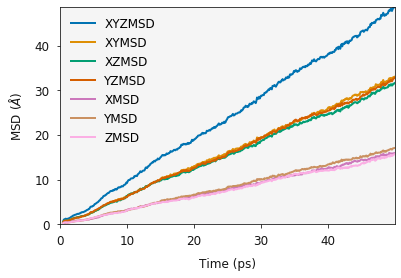

In [4]:
wr.msd_plot(output)

In [5]:
f_msd = RegionalMSD(history.trajectory, -10, 10, 0.1)
output = f_msd.analyse_trajectory()

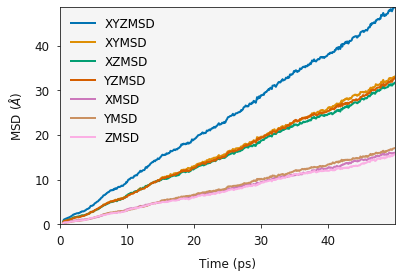

In [6]:
wr.msd_plot(output)

In [7]:
print(output.xyz_diffusion_coefficient())

1.6005368498765318
